### www.cmiw.cn 和 bbs.cmiw.cn 是爬虫web_crawler.ipynb爬下来的网页，本实验主要使用www.cmiw.cn 的数据

In [1]:
!dir

 驱动器 C 中的卷没有标签。
 卷的序列号是 D4A3-95FD

 C:\Users\Mark\1AI.NLP\AI.NLP\lecture7 的目录

2019-01-10  15:26    <DIR>          .
2019-01-10  15:26    <DIR>          ..
2019-01-04  16:34    <DIR>          .ipynb_checkpoints
2019-01-05  16:24    <DIR>          bbs.cmiw.cn
2019-01-04  17:21    <DIR>          log
2019-01-04  19:50           136,342 search_result.md
2019-01-10  15:26            41,652 simple_search_engine.ipynb
2019-01-07  15:02             8,415 web_crawler.ipynb
2019-01-04  19:05    <DIR>          www.cmiw.cn_archive
2019-01-04  19:37    <DIR>          www.cmiw.cn_text
               3 个文件        186,409 字节
               7 个目录 12,206,596,096 可用字节


In [2]:
import os

file_base = "www.cmiw.cn_archive" # html folder
text_base = "www.cmiw.cn_text" # text folder

### 爬虫爬到的是HTML文件，文本中含有标签，这里使用html2text将html处理为文本文件

In [6]:
import html2text

html_handler = html2text.HTML2Text()

html_handler.ignore_links = True

In [19]:
from tqdm import tqdm

for f in tqdm(os.listdir(file_base)):
    open(os.path.join(text_base, f),'w',encoding='utf-8').write(html_handler.handle(open(os.path.join(file_base, f)).read()))

100%|██████████████████████████████████████████████████████████████████████████████| 5592/5592 [03:50<00:00, 24.27it/s]


In [3]:
import os

len(os.listdir(text_base))

5592

### 把所有的内容作为语料库，先分词

In [4]:
import jieba

def cut(string): return ' '.join(jieba.cut(string))

In [6]:
from tqdm import tqdm

corpus = []

for f in tqdm(os.listdir(text_base)):
    corpus.append(cut(open(os.path.join(text_base, f),encoding = 'utf-8').read()))

  0%|                                                                                         | 0/5592 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Mark\AppData\Local\Temp\jieba.cache
Loading model cost 0.916 seconds.
Prefix dict has been built succesfully.
100%|██████████████████████████████████████████████████████████████████████████████| 5592/5592 [01:04<00:00, 86.20it/s]


### TF-IDF向量化，TF-IDF参考lecture6/TF_DF_wordcloud_relatedwords.ipynb

In [9]:
corpus[1]

'\n \n 3D 世界 网 旗下 网站 设 为 首页 收藏 本站 \n \n 开启 辅助 访问 \n \n 请   * * 登录 * *   后 使用 快捷 导航     \n 没有 帐号 ？ 注册 会员 \n \n ##   ! [ 机械 社区 ] ( static / image / common / logo . png ) \n \n 用户名   Email   |     |   自动 登录   |     找回 密码     \n - - - | - - - | - - - | - - -     \n 密码   |     |   _ 登录 _   |       注册 会员     \n     \n ! [ ] ( source / plugin / wechat / image / wechat _ login . png ) \n \n 扫一扫 ， 访问 微 社区 \n \n ! [ QQ 登录 ] ( static / image / common / qq _ login . gif ) \n \n 只 需 一步 ， 快速 开始 \n \n 快捷 导航 \n \n     *   门户 资讯 Portal \n     *   论坛 \n     *   导读 Guide \n     *   家园 Space \n     *   广播 免费 发布 商业信息 ， 登录 用户名 不变 ！ \n     *   社区 介绍 \n     *   淘帖 Collection \n     *   排行榜 Ranklist \n     *   充值 积分 \n     *   广告 服务 \n \n |     |   搜索   |   * * 搜索 * *   |     \n     \n - - - | - - - | - - - | - - - | - - -     \n     \n     *   帖子 \n     *   用户 \n \n ! [ ] ( / / img . alicdn . com / tps / TB1 _ 3FrKVXXXXbdXXXXXXXXXXXX - 129 - 128 . png )   安全 验证   _ \ue60c _ \n \n 请 完成 以下 验证码 \n \n 机械 社区   _ ›

### TfidfVectorizer 可以将文章进行TF-IDF向量化
- TF-IDF值表示词在某篇文章的重要性
- 本实验共有5000+文章，8w+词汇
- 如果文章没有该词，则TF-IDF为0

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

tf_idf_vec = vectorizer.fit_transform(corpus)

In [23]:
tf_idf_vec.shape

(5592, 84284)

In [24]:
tf_idf_vec.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02565131, 0.10289999, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1370599 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02232892, 0.10748669, 0.        , ..., 0.        , 0.        ,
        0.        ]])

### 转置之后就是词的倒排索引
- 若第v个词在第r篇文章中则transposed_tfidf_vec[v][r]不为0
- transposed_tfidf_vec[v][r]这个值表示了词在文章中的重要性

In [49]:
transposed_tfidf_vec = tf_idf_vec.transpose()

In [50]:
import numpy as np

transposed_tfidf_array = transposed_tfidf_vec.toarray()
transposed_tfidf_array.shape

(84284, 5592)

### Cosine距离是计算两个向量的方向差异度（0到1）

In [28]:
from scipy.spatial.distance import cosine

cosine([0,1],[1,0]) # 90度

1.0

In [31]:
cosine([1,1],[0,1]) # 45度

0.29289321881345254

In [33]:
cosine([1,3**0.2],[0,1]) # 30度 

0.2201751752678085

In [45]:
get_candidates_pat("中美贸易大战")

'(中|美|贸易|大战)'

In [43]:
def get_word_id(word):
    return vectorizer.vocabulary_.get(word, None)

def get_candidates_ids(input_string):
    return [get_word_id(c) for c in cut(input_string).split()]

def get_candidates_pat(input_string):
    return '({})'.format('|'.join(cut(input_string).split()))

### 根据词的编号找到索引的所有文章TF-IDF数组，然后用np.where(array)可以得到数组非0的坐标（数组索引）

In [46]:
get_word_id('深圳')

62650

In [54]:
import numpy as np

found_indexes = np.where(transposed_tfidf_array[62650])
found_indexes

(array([  21,   34,   68,  174,  181,  242,  243,  260,  297,  314,  374,
         386,  404,  451,  452,  459,  460,  462,  473,  490,  491,  495,
         500,  501,  572,  577,  578,  581,  597,  613,  617,  646,  647,
         648,  656,  658,  659,  661,  662,  668,  679,  680,  684,  685,
         686,  689,  691,  692,  697,  699,  704,  709,  713,  726,  728,
         730,  734,  735,  737,  740,  742,  743,  746,  754,  757,  760,
         761,  764,  778,  782,  784,  787,  790,  796,  797,  798,  804,
         806,  807,  815,  819, 3297, 3406, 3447, 3448, 3449, 3450, 3452,
        3481, 3532, 3586, 3647, 3692, 3705, 3771, 3772, 3802, 3806, 3808,
        3809, 3810, 3812, 3837, 3856, 3862, 3877, 3946, 3992, 4017, 4018,
        4024, 4035, 4036, 4037, 4038, 4046, 4058, 4068, 4080, 4081, 4082,
        4083, 4091, 4100, 4104, 4140, 4152, 4163, 4164, 4166, 4227, 4242,
        4243, 4244, 4272, 4292, 4306, 4316, 4332, 4336, 4391, 4472, 4512,
        4551, 4553, 4554, 4598, 4599, 

In [62]:
transposed_tfidf_array[62650][21]

0.024532110420052915

In [64]:
from operator import and_
from functools import reduce

reduce(and_, [{1,2,3},{3,4,5}])

{3}

In [69]:
np.where(vectorizer.transform([cut("深圳机械师")]).toarray()[0])

(array([58184, 62650], dtype=int64),)

### 以下仅使用了TF-IDF向量Cosine距离排序搜索结果
TODO：可以在爬虫爬数据时建立PageRank数据，最后根据PageRank+CosineDistance一起排序来获得更好的结果

In [44]:
from functools import reduce
from operator import and_
import re
from scipy.spatial.distance import cosine

def search_engine(query):
    candidates_ids = get_candidates_ids(query)
    
    v1 = vectorizer.transform([cut(query)]).toarray()[0]
    
    candidates = [set(np.where(transposed_tfidf_array[_id])[0]) for _id in candidates_ids]
    
    merged_candidates = reduce(and_, candidates)
    
    vector_with_id = [(tf_idf_vec[i], i) for i in merged_candidates]
    
    sorted_vector_with_ids = sorted(vector_with_id, key=lambda x: cosine(x[0].toarray(), v1))

    sorted_ids = [i for v, i in sorted_vector_with_ids]
    
    pat = re.compile(get_candidates_pat(query))
    for c in merged_candidates:
        output = pat.sub(repl='** \g<1> ** ', string=corpus[c])
        yield ''.join(output.split())

In [48]:
with open('search_result.md', 'w',encoding = 'utf-8') as f:
    for i, document in enumerate(search_engine('机械工程')):
        f.write('## search result {}\n'.format(i))
        f.write(document+'\n')
    print('done!')

done!


## Page Rank
### Refference https://blog.csdn.net/hguisu/article/details/7996185

In [1]:
import networkx as nx
import random
from string import ascii_letters

def generate_name(): return ''.join([random.choice(ascii_letters.upper()) for _ in range(3)])

In [2]:
social_graph = {
    "Yao": ['Guo', 'Wang', 'Tian', 'Tim'] + [generate_name() for _ in range(4)], 
    "Guo": ['Li'] + [generate_name() for _ in range(5)],
    "Wang": ["Li_2"] + [generate_name() for _ in range(5)], 
    "Li_2": [generate_name() for _ in range(5)], 
    "Li": [generate_name() for _ in range(1)],
}

In [3]:
social_network = nx.graph.Graph(social_graph)

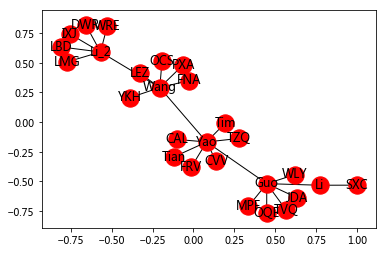

In [4]:
%matplotlib inline

nx.draw_networkx(social_network)

In [5]:
sorted(nx.pagerank(social_network).items(), key=lambda x: x[1], reverse=True)

[('Yao', 0.14018616244938112),
 ('Guo', 0.12625952492883674),
 ('Wang', 0.12354105488402628),
 ('Li_2', 0.11100157862592008),
 ('Li', 0.04009295437632798),
 ('SXC', 0.022595018111845305),
 ('LBD', 0.021279981196290158),
 ('LMG', 0.021279981196290158),
 ('DWR', 0.021279981196290158),
 ('IXJ', 0.021279981196290158),
 ('WRE', 0.021279981196290158),
 ('WLY', 0.02088716348418851),
 ('OQE', 0.02088716348418851),
 ('MPF', 0.02088716348418851),
 ('TVQ', 0.02088716348418851),
 ('JDA', 0.02088716348418851),
 ('YKH', 0.020557581368083087),
 ('OCS', 0.020557581368083087),
 ('LEZ', 0.020557581368083087),
 ('PXA', 0.020557581368083087),
 ('FNA', 0.020557581368083087),
 ('Tian', 0.020450012730142263),
 ('Tim', 0.020450012730142263),
 ('CVV', 0.020450012730142263),
 ('CAL', 0.020450012730142263),
 ('TZQ', 0.020450012730142263),
 ('FRV', 0.020450012730142263)]